In [128]:
import numpy as np
%tensorflow_version 2.x

import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import random
import tensorflow as tf
import cv2
#from skimage.measure import structural_similarity as ssim

# enable for scaling
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [129]:

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## TO DOs
### Feature Visualization
- Idea: Only use transformation robustneess for 500 steps and then run a few 100 more with it
- Data set examples for interpretability
    - find out the categories used
    - get imagenet examples
- Visualize batchnorm layers in comparison to add layers to see influence of residual connections

### Neb Algorithm

- try different distance measures
    - how would you redistribute evently according to a non euclidean distance?
- try if tangent computaion is different when pointing in direction of maximum or minimum activation
 
### Lucid
- more diverse visualizations using lucid


### General
- Fix graph unknown error


In [130]:
#@title Choose which network to use { form-width: "500px" }
model_name = "MobileNetV2" #@param ["MobileNetV2", "InceptionV3"]
model_func = "tf.keras.applications." + model_name + "(include_top=True, weights='imagenet')"
model = eval(model_func)
#model_V3 = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
#model_mobile_v1 = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')


- Inception V3 
    - shape 299, 299,3
    - -1 to 1
- Mobile Net
    - shape 224, 224, 3
    - -1 to 1

In [131]:

model.trainable = False
model.summary()
  
#model.load_graphdef()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [132]:

# Inception
# mixed9 100 biene mit händen

# Mobile
# 'block_8_project', 50 : Fluffy Stuff
# block_8_expand_BN 53: Wavy Eyes
# block_8_project_BN 30 Little Birds
#'block_12_add' 3: lights
# block_10_expand_relu 3: triangle stuff

# Then we define a new model that returns this channel as an output.
 

In [133]:
def l1_regularization(img,l = 0.005):
   return tf.convert_to_tensor(l * tf.math.reduce_sum(tf.math.abs(img)), dtype=tf.float32) 


def sigmoid(x):
   return 1/(1+np.exp(-x))
def random_jitter_lucid(img, jitter):
    img = tf.convert_to_tensor(img)
    img_shp = tf.shape(img)
    crop_shape = tf.concat([img_shp[:-3], img_shp[-3:-1] - jitter, img_shp[-1:]], 0)
    crop = tf.image.random_crop(img, crop_shape)
    shp = img.get_shape().as_list()
    mid_shp_changed = [
        shp[-3] - jitter if shp[-3] is not None else None,
        shp[-2] - jitter if shp[-3] is not None else None,
    ]
    crop.set_shape(shp[:-3] + mid_shp_changed + shp[-1:])
    return crop

    


def random_jitter_keras(img, max_jitter):

    amount = random.choice(np.arange(1, max_jitter+1))
    shape = tf.shape(img)
    hr = amount/shape[0]
    wr = amount/shape[1]
    
    img = tf.transpose(img)
    img = np.asarray(img)


    return tf.transpose(tf.keras.preprocessing.image.random_shift(img, wrg=wr, hrg=hr, fill_mode='reflect', interpolation_order=3))

 

def random_jitter(img, max_jitter):
    direction = random.choice(np.arange(0,4))
    amount = random.choice(np.arange(1,max_jitter+1))
    x,y,_ = img.shape
    new_img = np.zeros(img.shape, dtype=np.float32)
     
    if direction == 0:
        #down
        new_img[0:x-amount-1,:,:] = img[amount:x-1,:,:]
        new_img[x-amount-1:x-1,:,:] = 0 #img[x-1,:,:]
    if direction == 1:
        #up
        new_img[amount:x-1,:,:] = img[0:x-amount-1,:,:]
        new_img[0:amount,:,:] = 0 #img[0,:,:]
    if direction == 2:
        #right
        new_img[:,0:y-amount-1:,:] = img[:,amount:y-1,:]
        new_img[:,y-1,:] = 0 #img[:,y-1,:]
    if direction == 3:
        #left
        new_img[:,amount:y-1,:] = img[:,0:y-amount-1,:]
        new_img[:,0:amount,:] =  0 #img[:,,:]
    return tf.convert_to_tensor(new_img)

def random_scale(img, factors):
    #factor = random.choice(factors)
     
    #scaled = skimage.transform.rescale(img, factor)
    #resized = skimage.transform.resize(scaled,img.shape)
    #return tf.convert_to_tensor(resized) #, anti_aliasing=downsampling))

    img = tf.expand_dims(tf.convert_to_tensor(img),0)
    factor = random.choice(factors)
    shp = tf.shape(img)
    scale_shape = tf.cast(factor * tf.cast(shp[-3:-1], "float32"), "int32")
    return tf.squeeze(tf.compat.v1.image.resize_bilinear(img, scale_shape))
#tf.compat.v1.image.resize_bilinear

#def random_scale_tf(img, factors):
#        img = tf.convert_to_tensor(img, dtype=tf.float32)#
#
#        scale_shape= tf.shape(img)
#    return tf.image.resize_bilinear(t, scale_shape)


def random_rotate(img, degrees):

 
    angle = random.choice(degrees)
    angle = (360 + angle) % 360
    return scipy.ndimage.rotate(img, angle=angle, reshape=False, mode='wrap')

#def random_rotate(img, degrees):
#    print(tf.shape(img))
#    return tf.keras.preprocessing.image.random_rotation(img, 5, row_axis=1, col_axis=2, channel_axis=3)




In [134]:

def normalize_image(img):
    img = np.asarray(img,dtype=np.float32)
    return 2*(img - img.min()) / (img.max() - img.min()) - 1

def pixel_image(shape,sd=1, pixel_format='centered', init_val=None):
    if init_val != None:
        rnd_img = np.full(shape, init_val)
    else:
        rnd_img = np.random.normal(scale=1,size=shape)
    rnd_img = rnd_img.astype(np.float32)
    rnd_img = tf.nn.sigmoid(rnd_img)
    if pixel_format=='centered':
        rnd_img = (rnd_img-0.5)*2.0
    rnd_img = tf.convert_to_tensor(rnd_img,dtype=np.float32)
    return tf.Variable(rnd_img, trainable=True)

def transformation_robustness_test(img):
    # pad with 16 pixels
    img = tf.squeeze(img)
    x,y,_ = img.shape
    img = tf.pad(img, tf.constant([[6, 6,], [6, 6], [0, 0]]), "SYMMETRIC")
    # jitter with up to 8 pixels
    img = random_jitter_lucid(img,3)
    
    # scale with a random factor
    #img = random_scale(img, [1 + (i - 5) / 50. for i in range(11)]) # 0.9 - 1.1
    
    # rotate with random angle

    img = random_rotate(img,list(range(-10, 11)) + 5 * [0])
    # jitter up to 4 pixels
    img = random_jitter_lucid(img,3)

    x_2, _, _ = tf.shape(img)
    
    if x_2 < x:
        x_pad = int((x-x_2)/2)
        f_x = 0
        if (x-x_2)%2 == 1:
            f_x = 1
        
        img = tf.pad(img, tf.constant([[x_pad + f_x, x_pad], [x_pad + f_x, x_pad], [0, 0]]), "SYMMETRIC")
    else:
        img = tf.image.resize_with_crop_or_pad(img, x, y)
        #img = tf.image.random_crop(img, (x,y,3))


    #img = tf.image.crop_to_bounding_box(img, offset_height = 12, offset_width=12, target_height=x, target_width=y)
    return img


def transformation_robustness(img):
    # pad with 16 pixels
    img = tf.squeeze(img)
    x,y,_ = img.shape
    img = tf.pad(img, tf.constant([[6, 6,], [6, 6], [0, 0]]), "SYMMETRIC")
    # jitter with up to 8 pixels
    img = random_jitter_lucid(img,3)
    
    # scale with a random factor
    #img = random_scale(img, [1.025, 1.01, 0.975, 0.99, 1, 1, 1, 1]) # 0.9 - 1.1
    # rotate with random angle

    img = random_rotate(img,list(range(-3, 4)) + 5 * [0])
    # jitter up to 4 pixels
    img = random_jitter_lucid(img,3)

    x_2, _, _ = tf.shape(img)
    if x_2 < x:
        x_pad = int((x-x_2)/2)
        f_x = 0
        if (x-x_2)%2 == 1:
            f_x = 1
        
        img = tf.pad(img, tf.constant([[x_pad + f_x, x_pad], [x_pad + f_x, x_pad], [0, 0]]), "SYMMETRIC")
    else:
        img = tf.image.resize_with_crop_or_pad(img, x, y)


    #img = tf.image.crop_to_bounding_box(img, offset_height = 12, offset_width=12, target_height=x, target_width=y)
    return img


def scale_image(img):
    img = tf.squeeze(img)
    x, y, _ = tf.shape(img)
    img = random_scale(img, [1.5])
    return tf.expand_dims(tf.image.resize_with_crop_or_pad(img, x, y), 0)







In [135]:
list(range(-10, 11)) + 5 * [0]

[-10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 0,
 0,
 0,
 0,
 0]

In [136]:
 [1 + (i - 5) / 200. for i in range(11)] + 4*[1]

[0.975,
 0.98,
 0.985,
 0.99,
 0.995,
 1.0,
 1.005,
 1.01,
 1.015,
 1.02,
 1.025,
 1,
 1,
 1,
 1]

### Transformation Robustness
- Used in Distill Blog Post: for every step
    - pad 16 pixels 
    - jitter up to 16 pixels
    - scale with [1, 0.975, 1.025, 0.95, 1.05]
    - rotate with [5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    - jitter up to 8 pixels
    - crop padding
- only use transformations every x steps
    - every 5 steps: ok

In [137]:


# lucid code for decorrelating colors
# source lucid/lucid/optvis/param/color.py /


color_correlation_svd_sqrt = np.asarray([[0.26, 0.09, 0.02],
                                         [0.27, 0.00, -0.05],
                                         [0.27, -0.09, 0.03]]).astype("float32")
max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))

color_mean = [0.48, 0.46, 0.41]

def constrain_L_inf(x):
  return x / tf.maximum(1.0, tf.abs(x))


def _linear_decorelate_color(t):
  """Multiply input by sqrt of empirical (ImageNet) color correlation matrix.
  If you interpret t's innermost dimension as describing colors in a
  decorrelated version of the color space (which is a very natural way to
  describe colors -- see discussion in Feature Visualization article) the way
  to map back to normal colors is multiply the square root of your color
  correlations.
  """
  # check that inner dimension is 3?
  t_flat = tf.reshape(t, [-1, 3])
  color_correlation_normalized = color_correlation_svd_sqrt / max_norm_svd_sqrt
  t_flat = tf.matmul(t_flat, color_correlation_normalized.T)
  t = tf.reshape(t_flat, tf.shape(t))
  return t

def to_valid_rgb(t, decorrelate=False, sigmoid=True):
    """Transform inner dimension of t to valid rgb colors.
    In practice this consists of two parts:
    (1) If requested, transform the colors from a decorrelated color space to RGB.
    (2) Constrain the color channels to be in [0,1], either using a sigmoid
        function or clipping.
    Args:
        t: input tensor, innermost dimension will be interpreted as colors
        and transformed/constrained.
        decorrelate: should the input tensor's colors be interpreted as coming from
        a whitened space or not?
        sigmoid: should the colors be constrained using sigmoid (if True) or
        clipping (if False).
    Returns:
        t with the innermost dimension transformed.
    """
    if decorrelate:
        print("liner decor")
        t = _linear_decorelate_color(t)
    if decorrelate and not sigmoid:
        t += color_mean
    if sigmoid:
        return tf.nn.sigmoid(t)
    else:
        return constrain_L_inf(2*t-1)/2 + 0.5
 

In [138]:
# lucid code for fft
# source: lucid/lucid/optvis/param/spatial.py /

def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""
    # get x and y frequencies
    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    
    return np.sqrt(fx * fx + fy * fy)



def fft_image(shape, sd=None, decay_power=1):
    """An image paramaterization using 2D Fourier coefficients."""

    sd = sd or 0.01
    batch, h, w, ch = shape
    freqs = rfft2d_freqs(h, w)
    print(freqs.shape)
    init_val_size = (2, batch, ch) + freqs.shape
    print(init_val_size)

    init_val = np.random.normal(size=init_val_size, scale=sd).astype(np.float32)
    spectrum_real_imag_t = tf.Variable(init_val)
    spectrum_t = tf.complex(spectrum_real_imag_t[0], spectrum_real_imag_t[1])

    # Scale the spectrum. First normalize energy, then scale by the square-root
    # of the number of pixels to get a unitary transformation.
    # This allows to use similar leanring rates to pixel-wise optimisation.
    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale *= np.sqrt(w * h)
    scaled_spectrum_t = scale * spectrum_t

    # convert complex scaled spectrum to shape (h, w, ch) image tensor
    # needs to transpose because irfft2d returns channels first
    # signal instead of spectral for tf 2.0
    #image_t = tf.transpose(tf.spectral.irfft2d(scaled_spectrum_t), (0, 2, 3, 1))
    image_t = tf.transpose(tf.signal.irfft2d(scaled_spectrum_t), (0, 2, 3, 1))


    # in case of odd spatial input dimensions we need to crop
    image_t = image_t[:batch, :h, :w, :ch]
    image_t = image_t / 4.0  # TODO: is that a magic constant?
    return image_t

def image(
    w,
    h=None,
    batch=None,
    sd=None,
    decorrelate=True,
    fft=True,
    alpha=False,
    channels=None,
):
    h = h or w
    batch = batch or 1
    ch = channels or (4 if alpha else 3)
    shape = [batch, h, w, ch]
    param_f = fft_image if fft else pixel_image
    t = param_f(shape, sd=sd)
    if channels:
        output = tf.nn.sigmoid(t)
    else:
        output = to_valid_rgb(t[..., :3], decorrelate=decorrelate, sigmoid=True)
        if alpha:
            a = tf.nn.sigmoid(t[..., 3:])
            output = tf.concat([output, a], -1)
    return output

In [139]:
# my version of fourier coefficients


Differentiable Paramaterization
- What does lucid do?

1. decorrelate colours


In [140]:
def optimize_image(model, layer, unit, shape, lr=0.05, steps=512, total_variation=None, l1=None, blur=False, blur_step=1, blur_gradient=False, init_val=None, fft=False, decorrelate_colors=False, transformation=True, transformation_schedule = None, transformation_steps=1, use_optimizer=True, plot=False, plot_step = 100):
    """ Optimizes a random image to maximally activate the chosen unit of the chosen featuremap using gradient ascent

    Parameters
    ----------
    model: tf.keras.Model
        The Model to visualize
    layer: str
        the name of the layer
    unit: int
        unit of the layer
    shape: tuple
        (batch, height, width, channels)
    lr: float
        learning rate
    steps: int
        number of optimization steps
    fft: boolean
        use fourier trasnformed input if true
    decorrelate_colours: boolean
        decorrelate colours if true
    transformation: boolean
        if true applies transformation robustness 
    transforformation_steps: int
        apply transformations every transformation_steps step
    use_optimizer: boolean
        if True uses Adam Optimizer for Optimization

    returns
    -------
    img: tf.tensor
        optimized image

    """

    tf.keras.backend.clear_session()
   
     
 

    if use_optimizer:
        optimizer = tf.optimizers.Adam(lr)
  

    if fft:
        img = image(shape[1], decorrelate=decorrelate_colors, fft=fft)
    else:
        img = pixel_image(shape, init_val=init_val)
     

    
    # Update loop.
    average_activations = []
    plot_imgs = []
    steps_ar = []


    
  
    for step in range(steps):

        if transformation and step%transformation_steps == 0:
            img = tf.Variable(transformation_robustness(img))
            img = tf.expand_dims(img,0)

        #if step in [100,150,200,250,300,350,400]:
         #   img = tf.Variable(scale_image(img))
            



        with tf.GradientTape() as tape:
            tape.watch(img)
            # The gradient tape will not care about the image, because usually it is not a variable.
            # GradientTape has a method called 'watch', which can be used here.

             
            ######################
            #tape.watch(img)

            # Feed the image (remember to add batch dimension) to the model and compute the
            # average activation of the feature map. To get the average use 'tf.reduce_mean'.
            out_fm = visualization_model(img)
            average_activation = tf.reduce_mean(out_fm)
            # l1 or total cariation as penalty
            if total_variation != None:
                regularization_penalty = tf.image.total_variation(img) * total_variation
            elif l1 != None:
                regularization_penalty = l1_regularization(img, l=l1) 
            else:
                regularization_penalty = 0
 
            regularized_activity = average_activation - regularization_penalty 


            
            ######################
            
            # Compute the gradients to maximize the average activation in respect to the image.
            if use_optimizer:
                gradients = tape.gradient(-regularized_activity, img)
            else:
                gradients = tape.gradient(regularized_activity, img)
     
            ######################
        
        if blur_gradient:
            gradients = cv2.GaussianBlur(np.asarray(tf.squeeze(gradients)),(7,7), 1)
            gradients = tf.expand_dims(tf.convert_to_tensor(gradients),0)
             

        # Normalize gradients.

        gradients /= tf.math.reduce_std(gradients) + 1e-8
        img = tf.Variable(img)

        
        # Apply gradients to the image.
        if use_optimizer:
            optimizer.apply_gradients([(gradients, img)])
        else:
            img = img + lr*gradients
         




        if blur == 'bilateral' and step%blur_step == 0: 
            #sigma = 2 - sigmoid((step/steps - 0.5) * 8)
            img = cv2.bilateralFilter(np.asarray(tf.squeeze(img)), 7,0.5,0.6)
            img = tf.expand_dims(tf.convert_to_tensor(img),0)
        if blur == 'gaussian' and step%blur_step == 0: 
            #sigma = 0.7
            sigma = 1.5 - sigmoid((step/steps - 0.5) * 8)
            img = cv2.GaussianBlur(np.asarray(tf.squeeze(img)),(7,7), sigma)
            img = tf.expand_dims(tf.convert_to_tensor(img),0)




        ######################
        
        # Make sure values stay between -1 and 1.
        img = tf.clip_by_value(img, -1, 1)

        # store activations for plotting
        steps_ar.append(step)
        average_activations.append(average_activation)
        if step in [1,50]:

            plot_imgs.append(img)

        # Plot visualized feature all 50 steps:
        if step%plot_step == 0 and plot:
            print(average_activation.numpy())
            print(regularization_penalty)
            plt.figure(figsize=(5,5))
            plt.axis('off')
            img_show = tf.cast(255*(tf.squeeze(img) + 1.0)/2.0, tf.uint8)
            plt.imshow(img_show)
            plt.title("step: " + str(step) + "  average activation: "+ str(average_activations[-1].numpy()))
            plt.show()
    plot_imgs.append(img)
    
    if plot:
        plt.figure(figsize=(14,7))
        plt.title("average activation over optimization steps")
        plt.xlabel("steps")
        plt.ylabel("average activation")
        plt.plot(steps_ar, np.asarray(average_activations))

        fig = plt.figure(figsize=(5,5))
        plt.axis('off')
        img_show = tf.cast(255*(tf.squeeze(img) + 1.0)/2.0, tf.uint8)
        plt.imshow(img_show)
        plt.title("step: " + str(steps) + "  average activation: "+ str(average_activations[-1].numpy()))
        fig.savefig("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/plots/" + str(layer) + "_" + str(unit) + "_" + "TR" + ".png", bbox_inches='tight')

        plt.show()

#        fig = plt.figure(figsize=(15,5))
#        plt.subplots_adjust(wspace=0.05)
#        plt.subplot(1,3,1)
#        plt.axis('off')
#        img_show = tf.cast(255*(tf.squeeze(plot_imgs[0]) + 1.0)/2.0, tf.uint8)
#        plt.imshow(img_show)
#        plt.title("step: " + str(1)+ "  average activation: " + str(average_activations[0].numpy()))
#        plt.subplot(1,3,2)
#        plt.axis('off')
#        img_show = tf.cast(255*(tf.squeeze(plot_imgs[1]) + 1.0)/2.0, tf.uint8)
#        plt.imshow(img_show)
#        plt.title("step: " + str(50)+ "  average activation: " + str(average_activations[49].numpy()))
#        plt.subplot(1,3,3)
#        plt.axis('off')
#        img_show = tf.cast(255*(tf.squeeze(plot_imgs[2]) + 1.0)/2.0, tf.uint8)
#        plt.imshow(img_show)
#        plt.title("step: " + str(steps)+ "  average activation: " + str(average_activations[-1].numpy()))
#        fig.savefig("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/plots/" + str(layer) + str(unit) + ".png", bbox_inches='tight')
#        plt.show()
    return tf.squeeze(img)
            

In [141]:
# 'block_8_project', 50 : Fluffy Stuff

# block_10_expand_relu 3: triangle stuff
# block 11 add unit 1 lots of eyes
# block 11 add unit 27 flowers?
# block 11 add unit 32 arcs?
# units in block 11 and 12 seem to be similar

layer = 'block_12_add'


unit = 1

model = eval(model_func)

feature_map = model.get_layer(layer).output[:,:,:,unit] 


visualization_model = tf.keras.Model(
                            inputs=model.inputs, 
                            outputs=feature_map
                        )
#pivot1 = optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, fft=False, decorrelate_colors=False, transformation=False, use_optimizer=True, transformation_steps=1)

 
#pivot2 = optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=1024, total_variation=0.0003, fft=False, decorrelate_colors=False, transformation=False, use_optimizer=True, transformation_steps=1, plot=True)

pivot3 = optimize_image(visualization_model, layer, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, transformation=False, total_variation=0.0003, use_optimizer=True, transformation_steps=1, plot=True, plot_step=20)

#pivot4 = optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, fft=False, blur='bilateral', blur_step=3, decorrelate_colors=False, transformation=True, use_optimizer=True, transformation_steps=1, plot=True)

 
 

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# plotting


#### Visualize and store a layer

In [ ]:
units = range(96)
layer = 'block_10_project_BN'

for unit in units:
  
    model = eval(model_func)

    feature_map = model.get_layer(layer).output[:,:,:,unit] 


    visualization_model = tf.keras.Model(
                                inputs=model.inputs, 
                                outputs=feature_map
                            )
    img = optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, decorrelate_colors=False, transformation=True, use_optimizer=True, transformation_steps=1, plot=True)
    path = "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/"+ layer + "/" + str(unit) + "_my_implementation" + ".png"
    tf.keras.preprocessing.image.save_img(str(path), img)



#### Visualize for different learning rates

In [ ]:
# visualize for differebt learning rates
learning_rates = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
for lr in learning_rates:
    pivot2 = optimize_image(model, feature_map_2, unit=unit, shape=(1,224,224,3), lr=lr, steps=512, fft=False, decorrelate_colors=False, transformation=True, use_optimizer=True, transformation_steps=2)





## NEB Algorithm

In [142]:
def initialize_path(img1, img2, n_pivots):
    ''' Performs linear interpolation between img1 and img2 
    returns: n_pivots intermediate images '''
    interpolation_factors = np.linspace(0,1,n_pivots)
    #print(interpolation_factors)
    
    path = []
    for i in interpolation_factors:
        intermediate = np.zeros(img1.shape)
        intermediate = img1 * (1-i) + img2* i
        path.append(intermediate)
    #path.append(img2)
    return tf.convert_to_tensor(path, dtype=np.float32)
img1 = np.reshape(np.arange(0,224*224*3),(224,224,3))
img2 = np.reshape(np.arange(224*224*3,0,-1),(224,224,3))


def euclidian_distance(i1, i2):
    return np.sqrt(np.sum((i1-i2)**2))


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)



#n = 20
#imgs = initialize_path(pivot1, pivot2,n)
#print(euclidian_distance(imgs[0], imgs[1]))
#fig = plt.figure(figsize=(20,20))
#for i, img in enumerate(imgs):
#    plt.subplot(int(np.sqrt(n))+1,int(np.sqrt(n))+1,i+1)
#    plt.axis('off')
#    img_show = tf.cast(255*(img + 1.0)/2.0, tf.uint8)
#    plt.imshow(img_show)
#plt.show()

In [143]:
def check_interpolations(visualization_model, imgs, interpolation_steps, plot=False):
    '''
    Gets a list of images and interpolates linearly between them and computes the activations of the interpolations
    Checks if the interpolations have a lower activation
    '''
    interpolations = []
    interpolation_factors = np.linspace(0, 1, interpolation_steps, endpoint=False)
    
    for i in range(len(imgs)-1):
        img_1 = imgs[i]
        img_2 = imgs[i+1]
        
        for i in interpolation_factors:
            intermediate = np.zeros(img_1.shape)
            intermediate = img_1 * (1-i) + img_2* i
            interpolations.append(intermediate)
    interpolations.append(imgs[-1])
    batch = tf.convert_to_tensor(interpolations)
    out = visualization_model(batch)
    
    average_activations = tf.reduce_mean(out, axis=[1,2])
    reference_1 = 0
    reference_2 = interpolation_steps
    dense_enough = True
    for j in range(1,tf.shape(average_activations)[0]):
        if j == reference_2:
            reference_1 = reference_2
            reference_2 = j + interpolation_steps
        # 1 is an arbitrary threshold, come up with something smarter
        elif (average_activations[reference_1] - average_activations[j] > 1) and (average_activations[reference_2] - average_activations[j] > 2):
            dense_enough = False
        
    if plot:   
        color_categories = np.zeros(tf.shape(average_activations))
        mask = [i for i in range(0, average_activations.shape[0], interpolation_steps)]

        color_categories[mask] = 1

        plt.figure(figsize=(25,5))
        plt.title("Interpolation activations")
        plt.scatter(range(tf.shape(average_activations)[0]), average_activations, c=color_categories)
        plt.show()


    

    return dense_enough, np.asarray(average_activations), interpolations

In [144]:
# check the average activations of linear interpolation between the two starting images
imgs = initialize_path(pivot3, pivot4, 20)
batch = tf.convert_to_tensor(imgs)
activations = visualization_model(batch)
average_activations = tf.reduce_mean(activations, axis=[1,2])
plt.title("Linear interpolation activations")
plt.plot(range(tf.shape(average_activations)[0]), average_activations, 'o-')
plt.show()

NameError: ignored

In [145]:
def redistribute_pivots(pivots):

    # The curent distances between elements on chain
    current_distances = [euclidian_distance(pivots[i], pivots[i+1])for i in range(len(pivots)-1)]
    avg_distance = np.sum(current_distances)/(len(current_distances))
    # target positions are equally spaced by distance
    target_positions = np.cumsum(np.ones(len(current_distances)) * avg_distance)
    # First pivot remains unchanged
    new_pivots = [pivots[0]]
    # Put each new item measured along line on the line
    last_idx = 0  # Index of previous pivot
    pos_prev = 0.  # Position of previous pivot on chain
    pos_next = current_distances[last_idx]  # Position of next pivot on chain
    for i in range(1, len(current_distances)):
        position = target_positions[i - 1]
        while position > pos_next:
            last_idx += 1
            pos_prev = pos_next
            pos_next += current_distances[last_idx]

        t = (position - pos_prev) / (pos_next - pos_prev)
        new_pivots.append(t * pivots[last_idx + 1] + (1 - t) * pivots[last_idx])
    new_pivots.append(pivots[-1])

    return tf.convert_to_tensor(new_pivots)

def NEB(visualization_model, pivots, max_steps=1000, lr=0.1, total_variation=None,blur_gradient = True, plot=False):

    # reload model util Unknwon Graph error is fixed
     
    
    # generate intial path with n+2 pivots
    #pivots = initialize_path(img1, img2, n_pivots+2)
    steps_ar = []
    average_activations = []
    #pivot_storage = []
    #pivot_storage.append(pivots)

    # get starting activations
    out_fm = visualization_model(pivots)
    activations = tf.reduce_mean(out_fm, axis=[1,2])

    min_activation = tf.reduce_min(activations)
    
    max_activation = tf.reduce_max(activations)

    # get the minimum activation of img and img 2
    
    min_constant = tf.minimum(activations[0], activations[-1])

    # threhold for stopping
    threshold = min_constant # - (min_constant/min_activation)
    record_pivot = [pivots[int(len(pivots)/2)]]

 
    # run the optimization until either the maximum number of steps is reached or until each activations surpasses threshold
    step = 0
    while (not np.all(np.asarray(activations)[1:-1] > threshold) and step < max_steps) or step == 0:
        
        


        ### alternative gradient computation
        with tf.GradientTape() as tape:
            tape.watch(pivots)
            # feed images to network
            out_fm = visualization_model(pivots)
            activations = tf.reduce_mean(out_fm, axis=[1,2])
            if total_variation != None:
                regularization_penalty = tf.image.total_variation(pivots) * total_variation
            else:
                regularization_penalty = tf.zeros(tf.shape(pivots)[0])
            # compute gradients
            gradients = tape.gradient(activations-regularization_penalty, pivots)
            # normalize gradients
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            # no gradients for start and end image
            gradients = tf.convert_to_tensor(gradients[1:len(pivots)-1])

            if blur_gradient:
                b_gradients = []
                for g in gradients:
                    b_g = cv2.GaussianBlur(np.asarray(tf.squeeze(g)),(7,7), 1)
                    b_g = tf.convert_to_tensor(b_g)
                    b_gradients.append(b_g)
                gradients = tf.convert_to_tensor(b_gradients)

        ####

#        for pivot in pivots:
            # Compute projected loss force F for each pivot
#            with tf.GradientTape() as tape:
#                tape.watch(pivot)###
#
#                # Feed the image to the model and compute the average activation
#                out_fm = visualization_model(tf.expand_dims(pivot, 0))
#                average_activation = tf.reduce_mean(out_fm)
#                if total_variation != None:
#                    regularization_penalty = tf.image.total_variation(pivot) * total_variation
#                else:
#                    regularization_penalty = 0
#                gradients = tape.gradient(average_activation-regularization_penalty, pivot)
#                gradients /= tf.math.reduce_std(gradients) + 1e-8#
#
#            pivot_gradients.append(gradients)
 #           activations.append(average_activation)
 #       pivot_gradients = tf.convert_to_tensor(pivot_gradients[1:len(pivots)-1])
 #       pivot_gradients /= tf.math.reduce_std(pivot_gradients) + 1e-8
#
#        # check if activations of pivots is smaller than img1 and img2
        

        # Compute local tangent
        # point in direction of niehgbor with higher activation
        #tangents = [pivots[i+1] - pivots[i] if activations[i+1] > activations[i-1] else pivots[i] - pivots[i-1] for i in range(1,len(pivots)-1)]
        # point in direction of neighbor with lower activations
        tangents = [pivots[i+1] - pivots[i] if activations[i+1] < activations[i-1] else pivots[i] - pivots[i-1] for i in range(1,len(pivots)-1)]

        tangents = tangents / (tf.norm(tangents) + 1e-30)


        # Compute loss forces
        loss_force = gradients -(gradients * tangents) * tangents

        #loss_force = tf.concat(tf.zeros(img1.shape, dtype = np.float32), loss_force, tf.zeros(img1.shape, dtype = np.float32))

        # Apply loss forces

        
        new_pivots = []
        new_pivots.append(pivots[0])
        for i in range(1,len(pivots)-1):
            new_pivots.append(pivots[i] + lr * loss_force[i-1])
        new_pivots.append(pivots[-1])
        pivots = tf.convert_to_tensor(new_pivots)
 

        
        # redistribute pivots on path
        #distances = [euclidian_distance(pivots[i], pivots[i+1])for i in range(len(pivots)-1)]
        #print(distances)


        pivots =  redistribute_pivots(pivots)
        #pivot_storage.append(pivots)

        #
        

       
         
        steps_ar.append(step)
        average_activations.append(activations)
        #record_pivot.append(pivots[int(len(pivots)/2)])
        if step % 20 == 0 and plot:
            print("step:", step)
            #print("variation penalty:", regularization_penalty)
            # plot activations
            plt.figure(figsize=(15,5))
            plt.title("image activations")
            plt.ylim(min_activation-1, max_activation + 15)     
            plt.plot(range(len(activations)), activations, 'o-')
            plt.show()


            # plot images
            #plt.figure(figsize=(30,40))
            #for i,pivot in enumerate(pivots):
             #   plt.subplot(1,len(pivots),i+1)
             #   plt.axis('off')
             #   img_show = tf.cast(255*(pivot + 1.0)/2.0, tf.uint8)
             #   plt.imshow(img_show)
            #plt.plot(activations)
            #plt.show()
        step += 1
      
    

    return list(pivots), steps_ar, np.asarray(average_activations), record_pivot#, pivot_storage


In [146]:
def NEB_Wrapper(visualization_model, starting_images, n_pivots=20, max_steps=500, lr=0.005, total_variation=0.0015, blur_gradient = True, plot=False):
    ''' receives a list of optimized images and rund the NEB algorithm between neighboring images

    returns:
        images: list of optimized images
        activations: activations of images over the steps
        steps: list of steps
    '''
    final_images = []
    final_activations = []
    # keep track which images were starting images for plotting 
    start_positions = []
    for i in range(len(starting_images)-1):
        # go through images and perform NEB between them
        img1 = starting_images[i]
        img2 = starting_images[i+1]
        # linear interpolation as initial path
        pivots = initialize_path(img1, img2, n_pivots+2)
        images, steps, average_activation, _ = NEB(visualization_model, pivots, max_steps=max_steps, lr=lr, total_variation=total_variation, plot=plot)
        # check if interpolations have lower activations
        dense_enough, activations_i, interpolations = check_interpolations(visualization_model, images, interpolation_steps=3, plot=plot)
        if dense_enough:
            images = interpolations
            activations = activations_i
        else:
            # if interpolations have lower activations run NEB again with interpolations as extra pivots
            print("Sampling not dense enough, run NEB again with interpolations as pivots and half the steps")
            images, steps, average_activation_2, _ = NEB(visualization_model, tf.convert_to_tensor(interpolations), max_steps=max_steps, lr=lr, total_variation=total_variation, plot=plot)
            dense_enough, activations_i, interpolations = check_interpolations(visualization_model, images, interpolation_steps=1, plot=plot)
            # append activations for plotting

            #average_activation = np.append(average_activation, average_activation_2[:,range(0, average_activation_2.shape[1],3)], axis=0)
            
            if dense_enough:
                images = interpolations
                activations = activations_i
            else:
                print("still not dense enough")

        # append results, expect the last image as it is the first of the next sequence
        start_positions.append(len(final_activations))
        final_images.extend(images[:-1])
        final_activations.extend(activations[:-1])
        print("steps", steps[-1])

        # plot activations of individual pivots over steps
        if False:
            plt.figure(figsize=(25,10))

            average_activation_p = np.asarray(average_activation) 
            print("steps: ", steps[-1])
            plt.title("activations of images")
            plt.xlabel("steps")
            plt.ylabel("average activation")
            for i in range(average_activation_p.shape[1]):
                plt.plot(steps, average_activation_p[:,i])
            plt.show()

    # append last image for the last sequence
    final_images += [images[-1]]
    final_activations += [activations[-1]]
    start_positions.append(len(final_activations)-1)

    if plot:
        # plot final activations
        categories = np.zeros(len(final_activations),dtype=int)
        categories[start_positions] = 1
        final_activations=np.asarray(final_activations)
        plt.figure(figsize=(20,7))
        plt.xlabel("images")
        plt.ylabel("average activation")
        plt.title("final_activations")
        plt.scatter(range(len(final_activations)), final_activations, c=categories)
         

    return final_images, final_activations, start_positions





In [147]:
! ls "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/"
folders = glob.glob("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/*")
sample_dict = { i : x for i, x in enumerate(folders)}
print("Available Layers:")
for i in sample_dict:
  print(i, f": {os.path.basename(sample_dict[i])}")

block_10_project_BN  block_2_add	 block_5_add		 block_9_add
block_12_add	     block_3_project_BN  block_7_depthwise_relu
block_14_add	     block_4_add	 block_8_add
Available Layers:
0 : block_8_add
1 : block_9_add
2 : block_10_project_BN
3 : block_12_add
4 : block_14_add
5 : block_5_add
6 : block_4_add
7 : block_2_add
8 : block_3_project_BN
9 : block_7_depthwise_relu


In [148]:
#@title Choose which folder to use { form-width: "400px" }
FILE =  3#@param {type:"integer"}

foldername = sample_dict[FILE]

In [149]:
# load picture corresponding to unit

In [150]:
# load picture corresponding to unit

#folder_path = "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/" + foldername
path1 = foldername + "/" + str(unit) + "_lucid" + ".png"
#path2 = folder_path + feature_map_lucid + str(unit) + "nofft" + ".png"
print(path1)
pivot_lucid = np.asarray(tf.keras.preprocessing.image.load_img(path1), dtype=np.float32)
#pivot2 = np.asarray(tf.keras.preprocessing.image.load_img(path2), dtype=np.float32)
 
pivot_lucid = normalize_image(pivot_lucid)
#pivot2 = normalize_image(pivot2)

 

/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/block_12_add/1_lucid.png


#### Test NEB Algorithm

step: 0


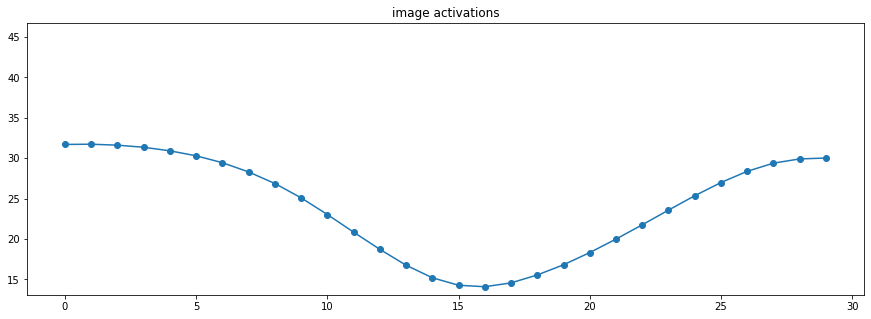

step: 20


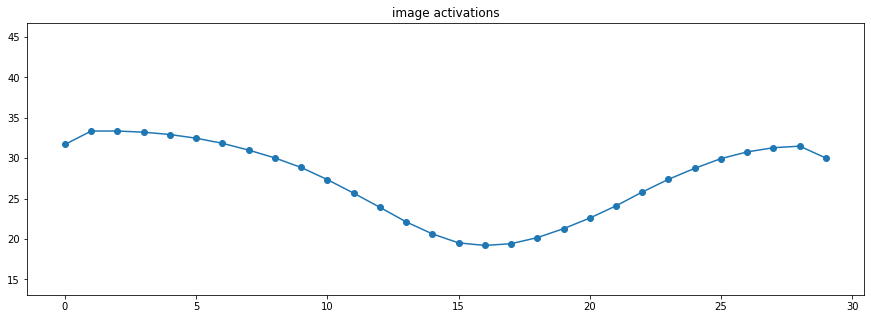

step: 40


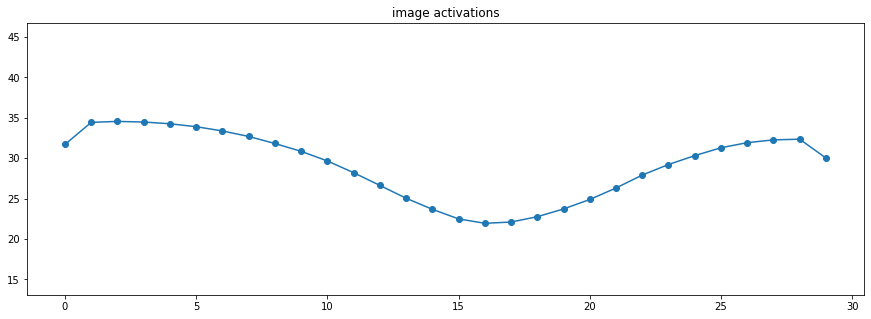

step: 60


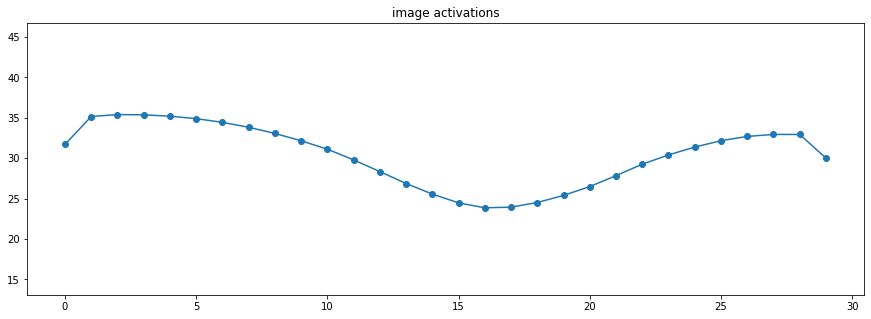

step: 80


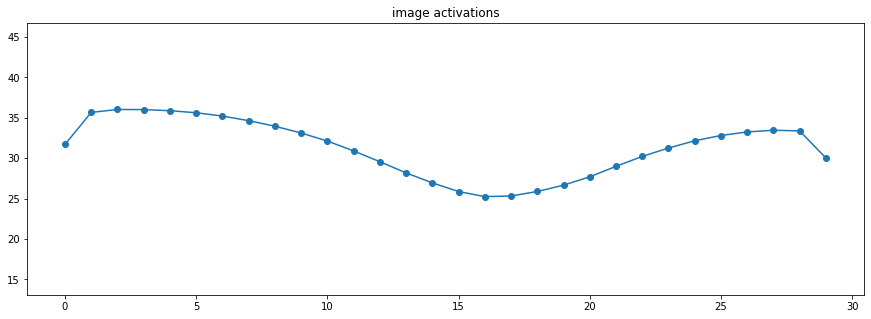

step: 100


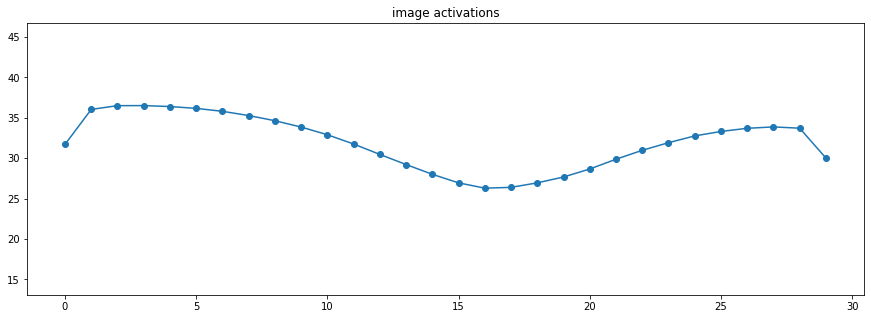

step: 120


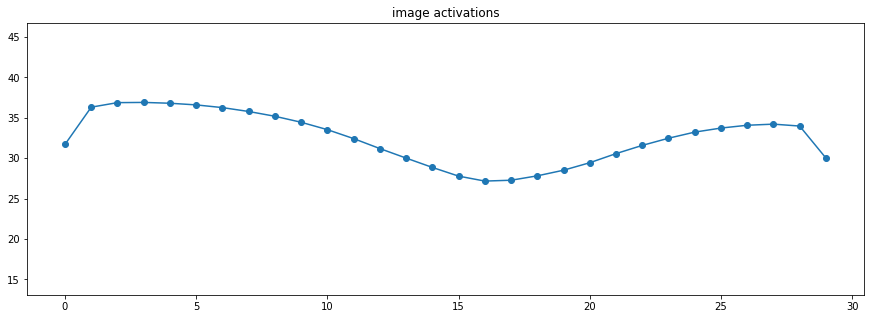

step: 140


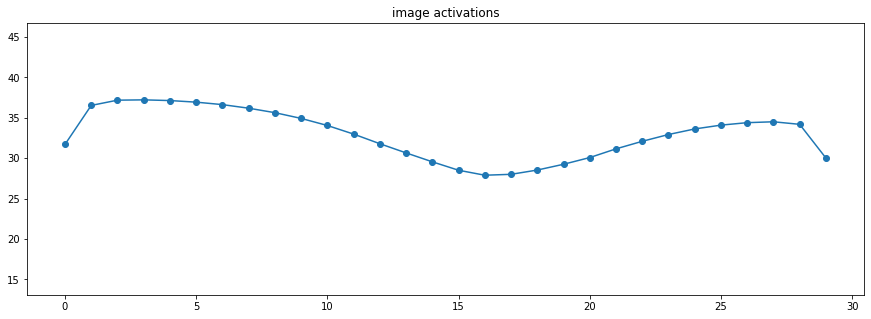

step: 160


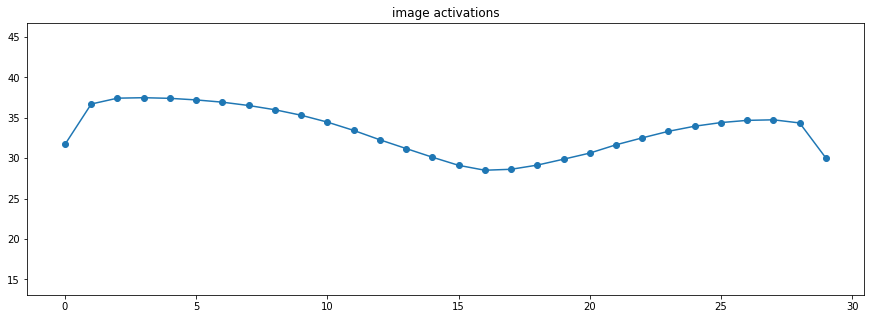

step: 180


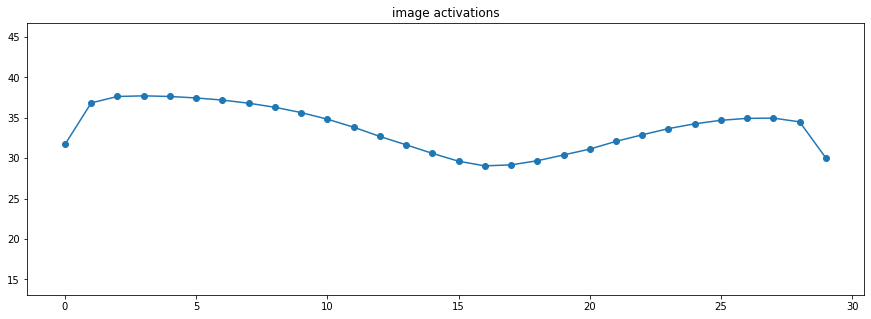

step: 200


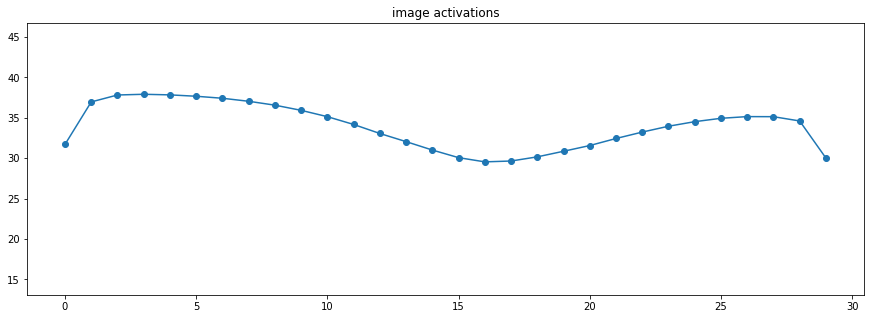

step: 220


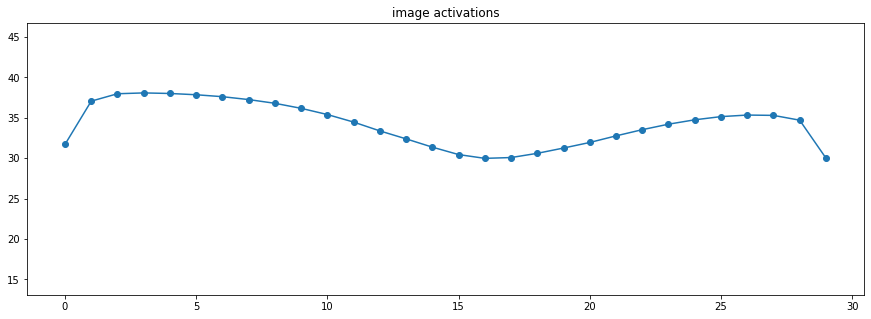

In [151]:
# Test NEB Algorithm
# test l1 and l2 regularization
# implement linear interpolation between pivots
#images, steps, average_activation = NEB(model=visualization_model, img1=pivot1, img2=pivot2, n_pivots=50, steps=50, lr=0.005)
starting_images = initialize_path(pivot3, pivot_lucid, 30)
images, steps, average_activation, record_pivot = NEB(visualization_model=visualization_model, pivots= starting_images, lr=0.001, blur_gradient = True, total_variation = 0.001, plot=True)




#### Test NEB Wrapper

In [ ]:
print(steps)

[0, 1, 2]


[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952
 0.57142857 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381
 0.85714286 0.9047619  0.95238095 1.        ]
step: 0


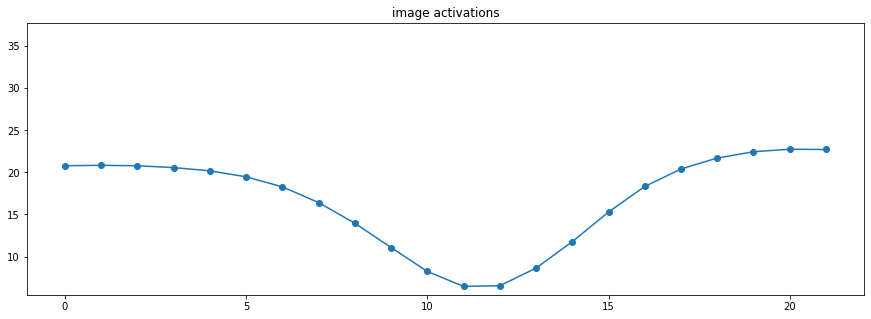

step: 20


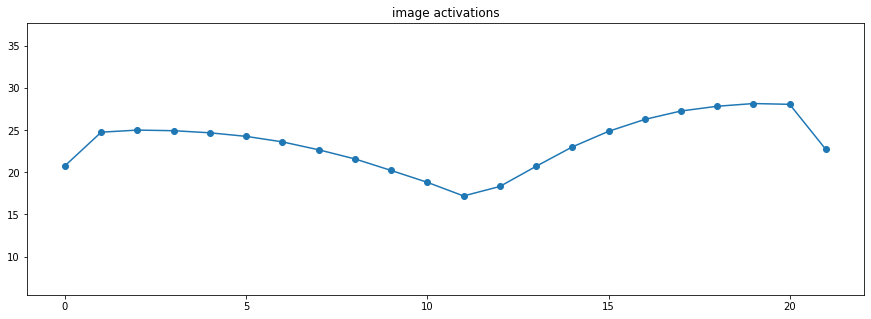

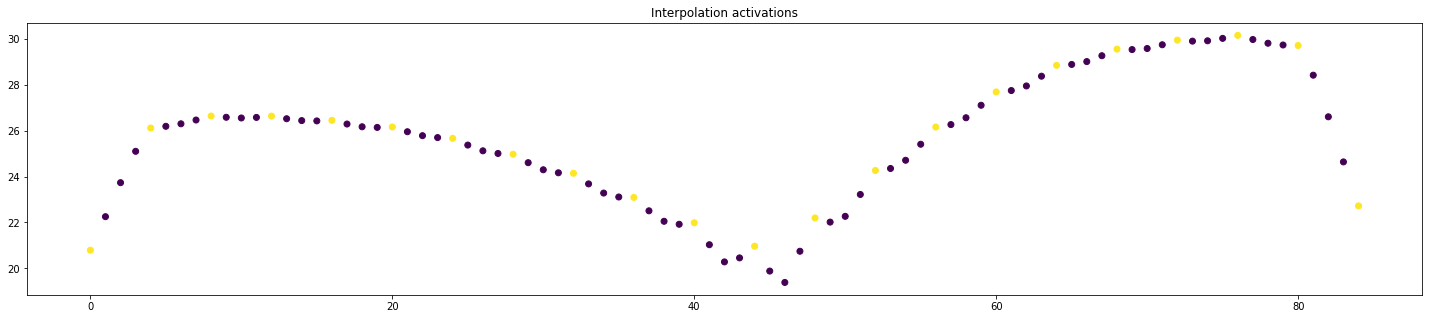

Sampling not dense enough, run NEB again with interpolations as pivots and half the steps
step: 0


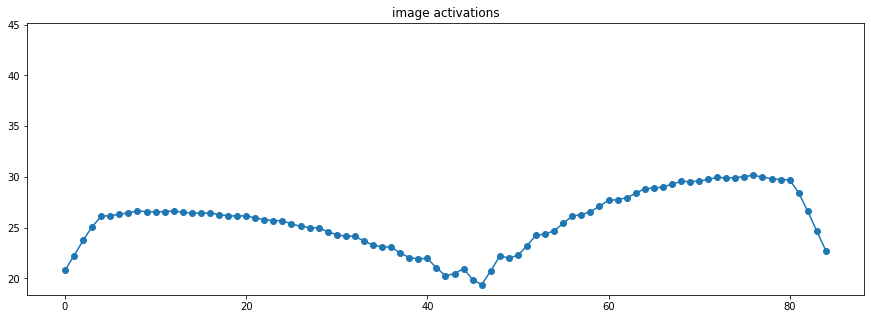

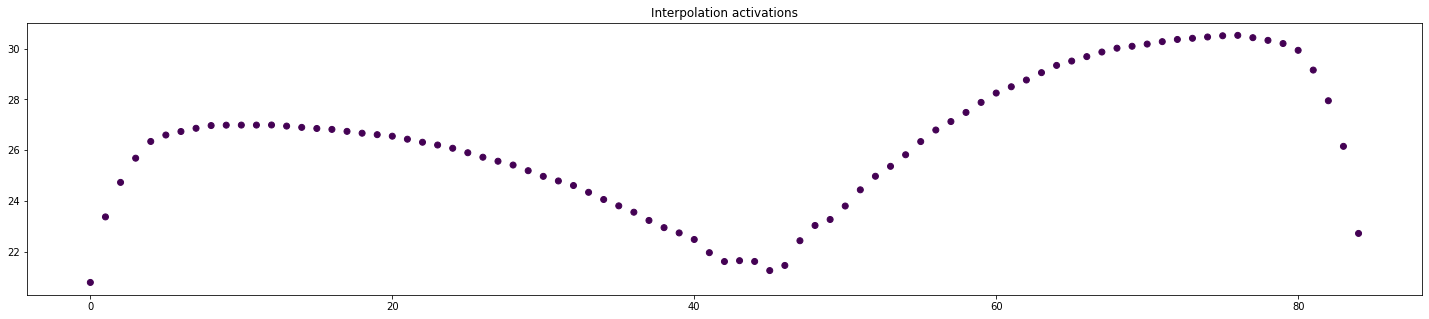

steps 4
[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952
 0.57142857 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381
 0.85714286 0.9047619  0.95238095 1.        ]
step: 0


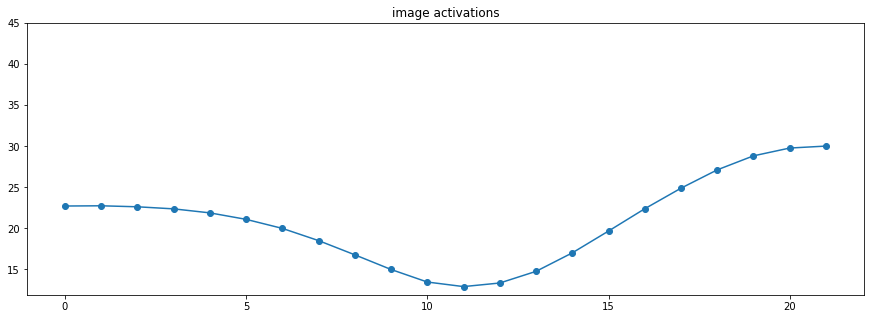

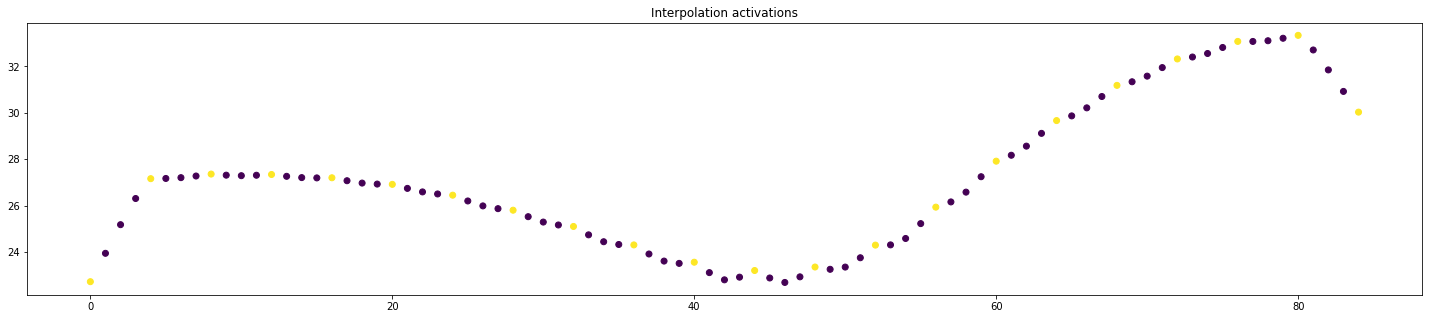

steps 14


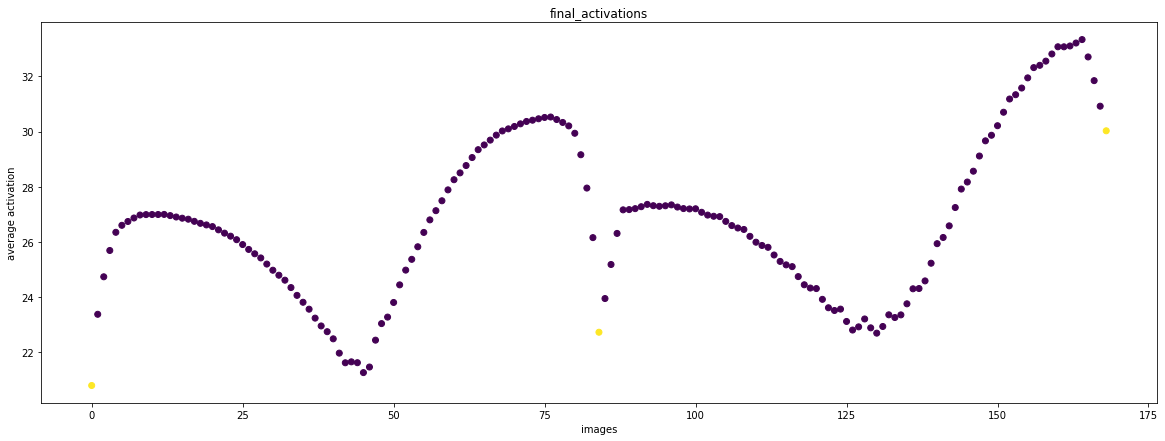

In [ ]:
images, activations, start_positions, record_pivot =  NEB_Wrapper(visualization_model, [pivot3, pivot4, pivot_lucid], n_pivots=20, max_steps=100, lr=0.001, total_variation=0.0005, plot=True)

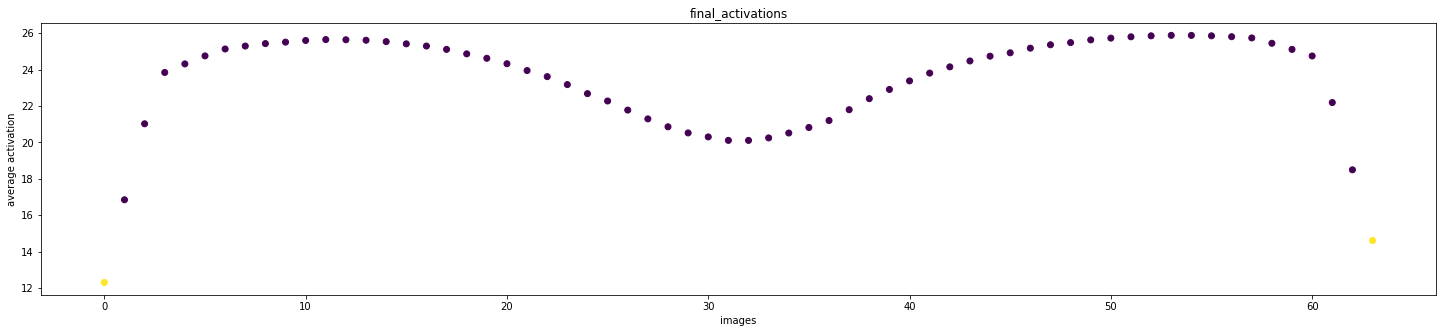

In [ ]:
# plot final activations
categories = np.zeros(len(activations),dtype=int)
categories[start_positions] = 1

activations=np.asarray(activations)
plt.figure(figsize=(25,5))
plt.xlabel("images")
plt.ylabel("average activation")
plt.title("final_activations")
plt.scatter(range(len(activations)), activations, c=categories)

plt.show()

True
activationsshape tf.Tensor([253  14  14], shape=(3,), dtype=int32)
True


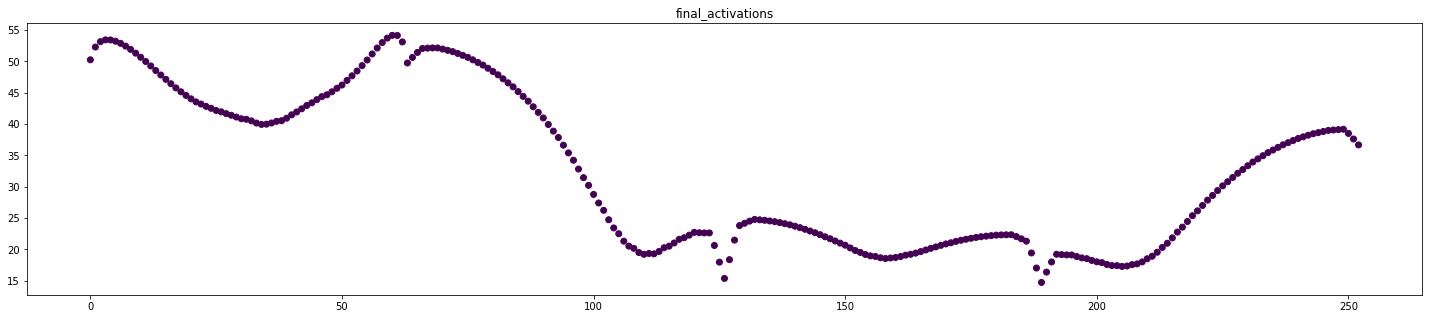

In [ ]:
# test if interpolations between pivots have a smaller activation
# interpolation steps including img1 and excluding img 2 example: 4 -> [0,0.25,0.5,0,75]
interpolation_steps = 1
print(np.all(np.asarray(activations) > 10))
dense, activations, _ = check_interpolations(visualization_model, images, interpolation_steps)
print(dense)
#print(tf.shape(activations))
color_categories = np.zeros(tf.shape(activations))
mask = [i for i in range(0, activations.shape[0], interpolation_steps)]

color_categories[mask] = 1

plt.figure(figsize=(25,5))
plt.title("final_activations")
plt.scatter(range(tf.shape(activations)[0]), activations, c=color_categories)
plt.show()

(45, 30) (45,)


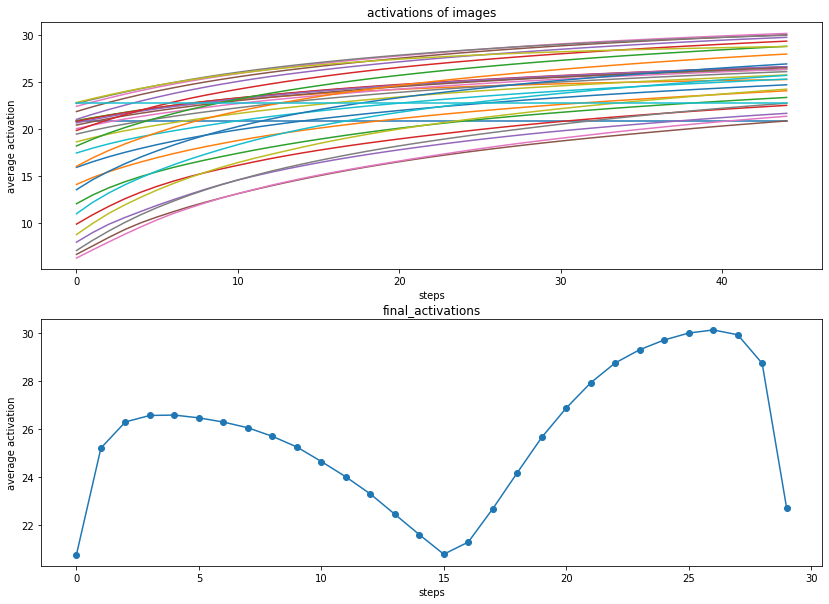

In [ ]:
# plot activations
average_activation = np.asarray(average_activation) 
steps = np.asarray(steps)
 
print(average_activation.shape,steps.shape)
plt.figure(figsize = (14,10))
plt.subplot(2,1,1)
plt.title("activations of images")
plt.xlabel("steps")
plt.ylabel("average activation")
for i in range(average_activation.shape[1]):
    plt.plot(steps, average_activation[:,i])
plt.subplot(2,1,2)
plt.xlabel("steps")
plt.ylabel("average activation")
plt.title("final_activations")
plt.plot(range(average_activation.shape[1]), average_activation[-1], 'o-')
plt.show()

In [231]:
from matplotlib import animation, rc
from IPython.display import HTML


#filename = str(feature_map) + str(unit) + ".mp4"
#path= r'/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Videos/' + filename

def animate_images(images, activations, fps=30, mirror=True, save_path=None):
    images_c = images.copy()
    activations = np.asarray(activations)
    if mirror:
        #images_r = images
        images_c = images_c + images_c[::-1]
        activations = np.append(activations, activations[::-1])
    plt_images = []
    n_images = range(len(images_c))

    fig = plt.figure(figsize=(17,7))
    ax = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax.set_axis_off()
    ax2.set_xticks(n_images)
    ax2.set_ylim(np.min(activations)-5,np.max(activations)+5)
    ax2.spines['bottom'].set_position(('data', np.min(activations)-4))
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)


    ax2.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax2.xaxis.set_ticklabels([])




    
    #fig.tight_layout()
    #plt.axis('off')
    #plt.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    #plt.gca().xaxis.set_major_locator(plt.NullLocator())
    #plt.gca().yaxis.set_major_locator(plt.NullLocator())
    for i,image in enumerate(images_c):
        
        #t = ax.annotate(str(activations[i]), xy=(0.8, 0.95), xytext =(0,0.5)) # add text

        
        #txt = plt.text(0,100,'text')
        t = plt.text(0.5, 0.95, str(activations[i]), horizontalalignment='center', verticalalignment='bottom', transform=ax2.transAxes)
        mark_on = [i]
        plt_ac,  = ax2.plot(n_images,activations, color='blue', marker='o', ms = 15, mfc = 'red', mec ='black', markevery = mark_on)
        #plt_ac,  = ax2.scatter(n_images,activations, marker='o', markevery = mark_on)

        #color_categories = np.zeros(activations.shape)
        #mask = [i]
        #color_categories[mask] = 1
        #plt_ac  = ax2.scatter(n_images,activations, c=color_categories)

        plt_image = ax.imshow(tf.cast(255*(image + 1.0)/2.0, tf.uint8), animated=True)
        #plt_image.text(0,0,'20')
        plt_images.append([plt_image, plt_ac, t])
    ani = animation.ArtistAnimation(fig, plt_images, interval=1000/fps, blit=True, repeat=True, repeat_delay=2000)
    if save_path != None:
        writer = animation.FFMpegWriter(fps=fps)
        ani.save(save_path, writer=writer)
    plt.close()
    rc('animation', html='jshtml')
    return HTML(ani.to_html5_video())




In [232]:
#imgs = initialize_path(pivot1, pivot2,60)
activations_plot = average_activation[-1,:]
fps = 30
video = animate_images(images, activations_plot, fps=fps, mirror=True)
video


22.940775


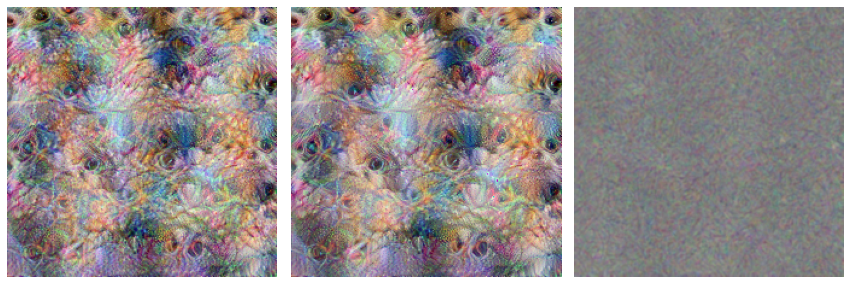

In [ ]:
# pivot analysis
img1 = record_pivot[0]
img2 = record_pivot[-1]

difference_img = img1-img2
print(euclidian_distance(img1,img2))

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1,3,1)
plt.axis('off')
img_show = tf.cast(255*(img1 + 1.0)/2.0, tf.uint8)
plt.imshow(img_show)
#plt.title("step: " + str(1)+ "  average activation: " + str(average_activations[0].numpy()))
plt.subplot(1,3,2)
plt.axis('off')
img_show = tf.cast(255*(img2 + 1.0)/2.0, tf.uint8)
plt.imshow(img_show)
#plt.title("step: " + str(50)+ "  average activation: " + str(average_activations[49].numpy()))
plt.subplot(1,3,3)
plt.axis('off')
img_show = tf.cast(255*(difference_img + 1.0)/2.0, tf.uint8)
plt.imshow(img_show)
#plt.title("step: " + str(steps)+ "  average activation: " + str(average_activations[-1].numpy()))
#fig.savefig("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/plots/" + str(layer) + str(unit) + ".png", bbox_inches='tight')
plt.show()

### Visualize Layer
Wrapping function which optimizes a few images with different strategies and then computes a video using NEB


In [ ]:
folders = glob.glob("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/images/*")
sample_dict = { i : x for i, x in enumerate(folders)}
print("Available Layers:")
for i in sample_dict:
  print(i, f": {os.path.basename(sample_dict[i])}")

Available Layers:
0 : block_8_add
1 : block_9_add
2 : block_10_project_BN
3 : block_12_add
4 : block_14_add
5 : block_5_add
6 : block_4_add
7 : block_2_add
8 : block_3_project_BN
9 : block_7_depthwise_relu


In [ ]:
#@title Choose which folder to use { form-width: "400px" }
FOLDER =  3#@param {type:"integer"}

foldername = sample_dict[FOLDER]

In [233]:
def animate_featuremap(visualization_model, img_paths=None, save_path=None, plot=False):

    '''
    Visualize the feature map defined by the given visualization model
    First optimizes images towards activation the feature map
    If paths are given, loads images optmized by other tools
    Then runs NEB between the images and creates an animation

    returns:
        animation: jshtml animation
    '''
    
    # optmize images
    input_images = []
    # naive optmization approach
     

    input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, fft=False, decorrelate_colors=False, transformation=False, use_optimizer=True, transformation_steps=1, plot=plot))

     


    # naive + total variation penalty
    input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, total_variation=0.0003, fft=False, decorrelate_colors=False, transformation=False, use_optimizer=True, transformation_steps=1, plot=plot))

    # transformation robustness
    input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, fft=False, decorrelate_colors=False, blur='bilateral', blur_step=True, use_optimizer=True, plot=plot))
    
    if img_paths != None:

        for path in img_paths:
            pivot_lucid = np.asarray(tf.keras.preprocessing.image.load_img(path), dtype=np.float32) 
            input_images.append(normalize_image(pivot_lucid))

    # transformation robusness +  faulty fft
    input_images.append(optimize_image(visualization_model, feature_map, unit=unit, shape=(1,224,224,3), lr=0.05, steps=512, fft=False, decorrelate_colors=False, transformation=True, use_optimizer=True, plot=plot))
    
    # 
     
    # run NEB
    images, final_activations, _ = NEB_Wrapper(visualization_model, input_images, n_pivots=20, max_steps=300, lr=0.005, total_variation=0.0008, plot=plot)

    # animate images
    ani = animate_images(images, np.asarray(final_activations), fps=30, mirror=True, save_path=save_path)

    return ani



        

In [234]:
# Test visualize layer
layer = 'block_12_add'

unit = 1

model = eval(model_func)

feature_map = model.get_layer(layer).output[:,:,:,unit] 


visualization_model = tf.keras.Model(
                            inputs=model.inputs, 
                            outputs=feature_map
                        )
filename = layer + str(unit) + "_1" + ".mp4"
save_path= r'/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Videos/' + filename
img_path1 = foldername + "/" + str(unit) + "_lucid" + ".png"


ani = animate_featuremap(visualization_model , save_path=save_path, plot=True)#, img_paths=[img_path1]
ani

Output hidden; open in https://colab.research.google.com to view.

#### Luke Talking Points

- Introduction
    - Introduction to deep learning
        - Rise of deep learning, especially in Computer Vision
        - function approximation and non-linearity
        - backpropagation and gradient descent
- Result presentation
    - How detailed optimization
        - Different learning rates
        - different transformation robusness schedules
    - Ideas for plot or further analysis
    -
- Ideas for Discussion
    - Difference Distance measures and their problems
    - NEB in Fourier space?
    - 
- General
    - image usage
        - ok if I credit people?